# Final 
By: Mitchell Humphrie

In [1]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib import animation
from itertools import combinations
from matplotlib import animation, rc
from IPython.display import HTML
from scipy.optimize import curve_fit

### Important Notes. Read me
1. For the variable staus, and the rows of status tracker:
    0 = uninfected
    1 = infected
    2 = recovered
    3 = dead (Dead are removed from area)
2. Death Probabulity and transProbabulity should both be integers 0-100

In [2]:
dt = 0.25

In [3]:
#Note for stats: 0 = not infected/ 1 = infected/ 2 = recovered/ 3 = dead
def overlaps(x1,y1,x2,y2,radius):
    xDis = abs(x2-x1)
    yDis = abs(y2-y1)
    hyp = (xDis**2 + yDis**2)**(1/2)
    return hyp < 2*radius

def makeBoxPlot(xPos,yPos,status,BS,timeStep):
    plt.figure(figsize = (2.9,2.9))
    time = timeStep*dt
    colorList = []
    for b in range(0,len(status)-1):
        if status[b] == 0:
               plt.plot(xPos[b],yPos[b],'o',color = 'b')
        if status[b] == 1:
               plt.plot(xPos[b],yPos[b],'o',color = 'y')
        if status[b] == 2:
               plt.plot(xPos[b],yPos[b],'o',color = 'g')
        if status[b] == 4:
               plt.plot(xPos[b],yPos[b],'o',color = 'r')


    plt.title('Simulation at t = {}'.format(time))
    plt.xlabel('X-Position (du)')
    plt.ylabel('Y-Position (du)')
    plt.xlim(0,BS)
    plt.ylim(0,BS)
    #plt.plot(xPos,yPos,'o',color = colorList)
    plt.show()
    

#####################################################################################

def runSim(nParticles, radius, velocity, infected, sheltered, TransProbability, deathProbability, boxSize, recoveryTime , timeMax, dt, draw):
    #Data returned from sim
    time = np.arange(0,timeMax+dt,dt)
    statusTracker = np.zeros(shape = (4,len(time)))
    
    #Data used to run sim
    xPos = np.zeros(nParticles)
    yPos = np.zeros(nParticles)
    xVel = np.zeros(nParticles)
    yVel = np.zeros(nParticles)
    infectedOn = np.zeros(nParticles)
    status = np.zeros(nParticles)
    
    recoveryNumber = int(recoveryTime/dt)
    
    #Set up intial particles
    for n in range(0,nParticles-1):
        found = 0
        #while found == 0:
        xPos[n] = np.random.uniform(0, boxSize)
        yPos[n] = np.random.uniform(0, boxSize)
        theta = np.random.uniform(0,2*m.pi)
        xVel[n] = velocity*np.cos(theta)
        yVel[n] = velocity*np.sin(theta)
        for i in range(0,n-1):
            if overlaps(xPos[i],yPos[i],xPos[n],yPos[n],radius):
                break
            else:
                found = 1
                    
    #Select random particles to be infected. 
    number = int(np.random.uniform(0,nParticles-1-infected))
    for n in range(0,infected):
        status[number+n] = 1
        infectedOn[number] = 0
        #print('infected 1') ##########################################
    
    #Select random particles to be locked in place
    number = int(np.random.uniform(0,nParticles-1-sheltered))
    for n in range(0,sheltered):
        xVel[number+n] = 0
        yVel[number+n] = 0
        #print('One is in shelter') ####################################
        
    #Make Main loop for time in the proccesses
    for i in range(0,len(time)):
        #print('Main Loop')
            
        for p in range(0,nParticles-1):
            #Advance particles forward by 1 dt
            
            xPos[p] = xPos[p] + xVel[p] * dt
            yPos[p] = yPos[p] + yVel[p] * dt
            
            if xPos[p] - radius < 0:
                xPos[p] = radius
                xVel[p] = -xVel[p]
            if yPos[p] - radius < 0:
                yPos[p] = radius
                yVel[p] = -yVel[p]
            if xPos[p] - radius > boxSize:
                xPos[p] = boxSize - radius
                xVel[p] = -xVel[p]
            if yPos[p] - radius > boxSize:
                yPos[p] = boxSize - radius
                yVel[p] = -yVel[p]

        #Take check for collitions, loop through every particle
        if i != 0:
            for n in range(0,nParticles-1):
                for j in range(0,nParticles-1):
                    if overlaps(xPos[n],yPos[n],xPos[j],yPos[j],radius): #If they overlap change directions and check if spreading
                        xVel[n] = -1*xVel[n]
                        yVel[n] = -1*yVel[n]
                        xVel[j] = -1*xVel[j]
                        yVel[j] = -1*yVel[j]
                        
                        if TransProbability != 100:
                            number = int(np.random.uniform(0,100/TransProbability))
                            if number == 1:
                                #Spread the Disease if needed
                                if status[n] == 1 or status[j] == 1:
                                    if status[n] == 1 and status[j] == 0:
                                        status[j] = 1
                                        infectedOn[j] = i
                                        #print("Infection Spread") ###########
                                    if status[n] == 0 and status[j] == 1:
                                        status[n] = 1
                                        infectedOn[n] = i
                                        #print("Infection Spread") ###########
                        else:
                            if status[n] == 1 or status[j] == 1:
                                    if status[n] == 1 and status[j] == 0:
                                        status[j] = 1
                                        infectedOn[j] = i
                                        #print("Infection Spread") ###########
                                    if status[n] == 0 and status[j] == 1:
                                        status[n] = 1
                                        infectedOn[n] = i
                                        #print("Infection Spread") ###########
                            
                   

                
        #Check to see if anyone is recvoered yet
        for k in range(0, nParticles-1):
            if (i == (recoveryNumber + infectedOn[k])) and (status[k] == 1):
                status[k] = 2
              
        if deathProbability != 0:
            for k in range(0,nParticles-1):
                if status[k] == 1:
                    number = int(np.random.uniform(0,(100/deathProbability)*recoveryTime))
                    if number == 1:
                        xVel[k] = 0
                        yVel[k] = 0
                        xPos[k] = -5
                        yPos[k] = -5
                        status[k] = 3
                        

        #Gather all data to but in statsTracker
        s0 = 0
        s1 = 0
        s2 = 0
        s3 = 0
        for s in range(1, nParticles):
            if status[s] == 0:
                 s0 = s0 + 1
            if status[s] == 1:
                 s1 = s1 + 1
            if status[s] == 2:
                 s2 = s2 + 1
            if status[s] == 3:
                s3 = s3 +1
                        
        statusTracker[0,i] = s0
        statusTracker[1,i] = s1
        statusTracker[2,i] = s2
        statusTracker[3,i] = s3
        
        if(draw == True and i == 0): #Start
            makeBoxPlot(xPos,yPos,status,boxSize,i)
            
        if(draw == True and i == int(len(time)/3)): #15s
            makeBoxPlot(xPos,yPos,status,boxSize,i)
           
        if(draw == True and i == int(len(time) * (2/3))): #30s
            makeBoxPlot(xPos,yPos,status,boxSize,i)
           
        if(draw == True and i == len(time)-1): #45s
            makeBoxPlot(xPos,yPos,status,boxSize,i)
        
        
        
    return time, statusTracker


#######################################################################################################
def printResults(statusTracked):
    
    startedInfected = statusTracked[1,0]
    peakInfected = max(statusTracked[1,:])
    peakTime = int(np.argmax(statusTracked[1,:])*dt)
    totalInfected = statusTracked[1,len(statusTracked[1])-1] + statusTracked[2,len(statusTracked[1])-1] +  statusTracked[3,len(statusTracked[1])-1]
    totalDead = statusTracked[3,len(statusTracked[1])-1]
    
    print('Started with infections: {} '.format(startedInfected)) 
    print('Peak Infecttions: {} at time {}'.format(peakInfected, peakTime))
    print('Total Infections: {}'.format(totalInfected) )
    print('Total Deaths: {}'.format(totalDead))


####################################################################################################   
def plotStatus(time,tracker):
    plt.close()
    plt.figure(figsize=(2.9,2.9))
    plt.plot(time, tracker[0,:], label = "Vulnerable")
    plt.plot(time, tracker[1,:], label = "Infected")
    plt.plot(time, tracker[2,:], label = "Recovered")
    #If there is a death rate/ people die, include it on graph
    if max(tracker[3,:]) > 0:
        plt.plot(time, tracker[3,:], label = "Dead")
    plt.title('Population Status vs Time')
    plt.xlabel('Time (time unit)')
    plt.ylabel('Number of People')
    plt.legend(loc = 'upper right')
    plt.show()
######################################################################################################   
def plotStack(time, tracker):
    #Get infor for each label placement
    names = ['Vulnerable','Infected','Recovered']
    x0 = 5
    y0 = 5
    x1 = int(np.argmax(tracker[1,:])*0.05)+10
    y1 = int(max(tracker[1,:]))
    x2 = 35
    y2 = 185
    
    plt.close()
    fig, ax = plt.subplots(figsize=(2.9,2.9))
    ax.stackplot(time, tracker[0,:], tracker[1,:], tracker[2,:])
    ax.set_title('Population Status vs Time')
    ax.set_xlabel('Time (time unit)')
    ax.set_ylabel('Number of People')
    ax.text(x0, y0, names[0])
    ax.text(x1, y1, names[1])
    ax.text(x2, y2, names[2])
    plt.show()
    
#########################################################################################  

def plotStackDeath(time, tracker):
    #Get infor for each label placement
    names = ['Vulnerable','Infected','Recovered','Dead']
    x0 = 5
    y0 = 5
    x1 = int(np.argmax(tracker[1,:])*dt)
    y1 = int(max(tracker[1,:]))
    x2 = int(np.argmax(tracker[2,:])*dt)-5
    y2 = int(max(tracker[2,:]))-20
    x3 = 35
    y3 = 185
    
    plt.close()
    fig, ax = plt.subplots(figsize=(2.9,2.9))
    ax.stackplot(time, tracker[0,:], tracker[1,:], tracker[2,:], tracker[3,:])
    ax.set_title('Infected Status vs Time')
    ax.set_xlabel('Time (time unit)')
    ax.set_ylabel('Count')
    ax.text(x0, y0, names[0])
    ax.text(x1, y1, names[1])
    ax.text(x2, y2, names[2])
    ax.text(x3, y3, names[3])
    plt.show()
    

In [4]:
#Line fit stuff

def linFit(x, m, b):
    return x*m + b

def expFit(x,p,b):
    return ((x**p) + b)

def myLinFit(xArray,yArray):
    param, paramCov = curve_fit(linFit, xArray, yArray)
    yFit = []
    for i in xArray:
        yFit.append(linFit(i,param[0],param[1]))
    slope = param[0]
    B = param[1]
    
    return yFit,slope,B

def myExpFit(xArray,yArray):
    param, paramCov = curve_fit(expFit, xArray, yArray)
    yFit = []
    for i in xArray:
        yFit.append(expFit(i,param[0],param[1]))
    power = param[0]
    B = param[1]
    
    return yFit,power,B

# Control group

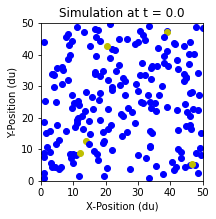

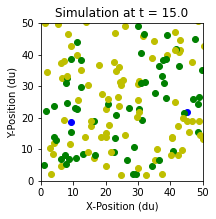

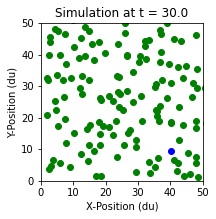

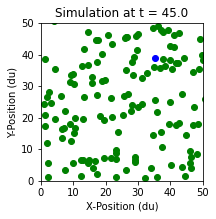

Started with infections: 5.0 
Peak Infecttions: 150.0 at time 9
Total Infections: 197.0
Total Deaths: 61.0


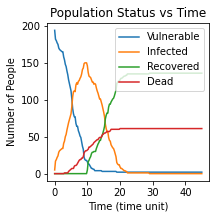

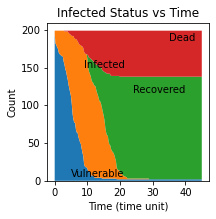

In [5]:
#nParticles, radius, velocity, infected, sheltered, TransProbability, deathProbability, boxSize, recoveryTime , timeMax
#                                          n   r    v   inf  she  TP   DP  BS    RT  tmax  dt
controlDeadtime, controlTracked = runSim(200, 1.0, 2.0, 5,    0, 100, 10, 50, 10, 45, dt, True)
printResults(controlTracked)
plotStatus(controlDeadtime,controlTracked)
plotStackDeath(controlDeadtime,controlTracked)


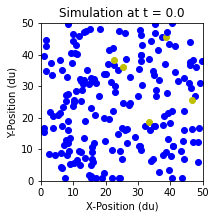

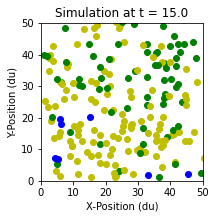

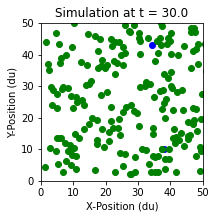

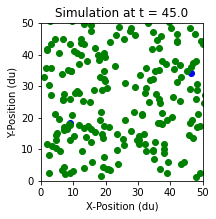

Started with infections: 5.0 
Peak Infecttions: 150.0 at time 11
Total Infections: 196.0
Total Deaths: 0.0


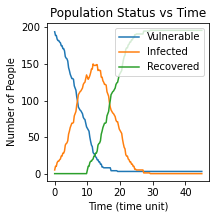

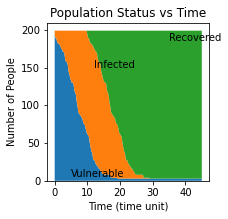

In [6]:


#nParticles, radius, velocity, infected, sheltered, TransProbability, deathProbability, boxSize, recoveryTime , timeMax, 
#                        n   r    v   inf she TP   DP  BS  RT  tmax  dt
time1, tracked1 = runSim(200, 1.0, 2.0, 5, 0, 100, 0, 50, 10, 45, dt, True)
printResults(tracked1)
plotStatus(time1,tracked1)
plotStack(time1,tracked1)


# Shlelter in Place

In [7]:
#Test how sheltering in place works out

#nParticles, radius, velocity, infected, sheltered, TransProbability, deathProbability, boxSize, recoveryTime , timeMax, dt
#                        n   r    v   inf she TP   DP  BS  RT  tmax  
numberSheltering = np.arange(0,200,20)
peakInfected = np.zeros(len(numberSheltering))
peakAt = np.zeros(len(numberSheltering))

print(numberSheltering)

loopNum = 3
#Gather all peak values
for v in range(len(numberSheltering)):
    peak = np.zeros(loopNum)
    peaktime = np.zeros(loopNum)
    for i in range(0,loopNum):
        time, tracked = runSim(200, 1.0, 2.0, 5, numberSheltering[v], 100, 0, 50, 10, 45, dt, False)
        peak[i] = max(tracked[1,:])
        peaktime[i] = int(np.argmax(tracked[1,:])*dt)

    peakAt[v] = sum(peaktime)/len(peaktime)
    peakInfected[v] = sum(peak)/len(peak)
    #plotStatus(time,tracked)

[  0  20  40  60  80 100 120 140 160 180]


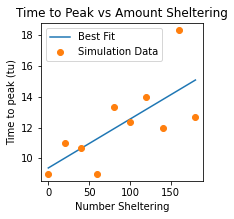

Best fit equation: time = 0.03x + 9.37


In [8]:
#Get best fit perameters
fitPeakAtST, slopeST, BST = myLinFit(numberSheltering, peakAt)

#Plot peaks vs time
plt.close()
plt.figure(figsize=(2.9,2.9))
plt.plot(numberSheltering,fitPeakAtST,label = 'Best Fit')
plt.plot(numberSheltering, peakAt,'o',label = 'Simulation Data')
plt.title('Time to Peak vs Amount Sheltering')
plt.xlabel('Number Sheltering')
plt.ylabel('Time to peak (tu)')
plt.legend(loc = 'upper left')
plt.show()

print('Best fit equation: time = {:.2f}x + {:.2f}'.format(slopeST,BST))

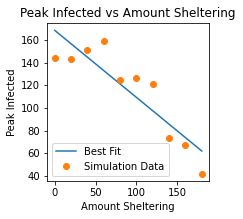

Best fit equation: time = -0.59x + 168.44


In [9]:
#Get best fit line:
fitPeakInfectedST, slopePIST, BPIST = myLinFit(numberSheltering, peakInfected)

plt.close()
plt.figure(figsize=(2.9,2.9))
plt.plot(numberSheltering, fitPeakInfectedST,label = 'Best Fit')
plt.plot(numberSheltering, peakInfected,'o',label = 'Simulation Data')
plt.title('Peak Infected vs Amount Sheltering')
plt.xlabel('Amount Sheltering')
plt.ylabel('Peak Infected')
plt.legend(loc = 'lower left')
plt.show()

print('Best fit equation: time = {:.2f}x + {:.2f}'.format(slopePIST,BPIST))

# Increase social distancing

In [10]:
#Test how the size of the box effects the system 

#nParticles, radius, velocity, infected, sheltered, TransProbability, deathProbability, boxSize, recoveryTime , timeMax, dt
#                        n   r    v   inf she TP   DP  BS  RT  tmax  

boxSizeArray = np.arange(50,110,10)
peakInfectedBS = np.zeros(len(boxSizeArray))
peakAtBS = np.zeros(len(boxSizeArray))

print(boxSizeArray)

loopNum = 3
#Gather all peak values
for v in range(len(boxSizeArray)):
    peak = np.zeros(loopNum)
    peaktime = np.zeros(loopNum)
    for i in range(0,loopNum):
        time, tracked = runSim(200, 1.0, 2.0, 5, 0 , 100, 0, boxSizeArray[v], 10, 45, dt, False)
        peak[i] = max(tracked[1,:])
        peaktime[i] = int(np.argmax(tracked[1,:])*dt)

    peakAtBS[v] = sum(peaktime)/len(peaktime)
    peakInfectedBS[v] = sum(peak)/len(peak)
    #plotStatus(time,tracked)

[ 50  60  70  80  90 100]


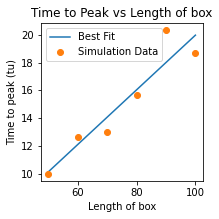

Best fit equation: time = 0.20x + 0.27


In [11]:
#Get best fit perameters
fitPeakAtBS, slopeBS, BBS = myLinFit(boxSizeArray, peakAtBS)

#Plot peaks vs time
plt.close()
plt.figure(figsize=(2.9,2.9))
plt.plot(boxSizeArray, fitPeakAtBS,label = 'Best Fit')
plt.plot(boxSizeArray, peakAtBS,'o',label = 'Simulation Data')
plt.title('Time to Peak vs Length of box')
plt.xlabel('Length of box')
plt.ylabel('Time to peak (tu)')
plt.legend(loc = 'upper left')
plt.show()

print('Best fit equation: time = {:.2f}x + {:.2f}'.format(slopeBS,BBS))

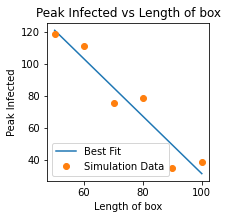

Best fit equation: time = -1.79x + 210.87


In [12]:
#Get best fit perameters
fitPeakInfectedBS, slopeInfectedBS, BInfectedBS = myLinFit(boxSizeArray, peakInfectedBS)

#Plot peaks vs time
plt.close()
plt.figure(figsize=(2.9,2.9))
plt.plot(boxSizeArray, fitPeakInfectedBS,label = 'Best Fit')
plt.plot(boxSizeArray, peakInfectedBS,'o',label = 'Simulation Data')
plt.title('Peak Infected vs Length of box')
plt.xlabel('Length of box')
plt.ylabel('Peak Infected')
plt.legend(loc = 'lower left')
plt.show()

print('Best fit equation: time = {:.2f}x + {:.2f}'.format(slopeInfectedBS,BInfectedBS))

# Reducing transmition probability


In [13]:
#Test how a change in transmition probablility 

#nParticles, radius, velocity, infected, sheltered, TransProbability, deathProbability, boxSize, recoveryTime , timeMax, dt
#                        n   r    v   inf she TP   DP  BS  RT  tmax  

transArray = np.arange(20,120,20)
peakInfectedPT = np.zeros(len(transArray ))
peakAtPT = np.zeros(len(transArray ))

print(transArray)

loopNum = 3
#Gather all peak values
for v in range(len(transArray)):
    peak = np.zeros(loopNum)
    peaktime = np.zeros(loopNum)
    for i in range(0,loopNum):
        time, tracked = runSim(200, 1.0, 2.0, 5, 0 , transArray[v], 0, 50, 10, 45, dt, False)
        peak[i] = max(tracked[1,:])
        peaktime[i] = int(np.argmax(tracked[1,:])*dt)

    peakAtPT[v] = sum(peaktime)/len(peaktime)
    peakInfectedPT[v] = sum(peak)/len(peak)
    #plotStatus(time,tracked)

[ 20  40  60  80 100]


[12.33333333 10.33333333 11.33333333 12.          9.66666667]
[139.         139.33333333 138.         120.66666667 165.        ]


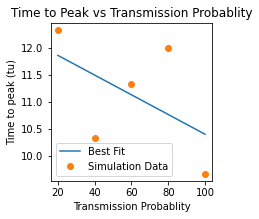

Best fit equation: time = -0.02x + 12.23


In [14]:
print(peakAtPT)
print(peakInfectedPT)

#Get best fit perameters
fitPeakAtPT, slopePT, BPT = myLinFit(transArray, peakAtPT)

#Plot peaks vs time
plt.close()
plt.figure(figsize=(2.9,2.9))
plt.plot(transArray, fitPeakAtPT,label = 'Best Fit')
plt.plot(transArray, peakAtPT,'o',label = 'Simulation Data')
plt.title('Time to Peak vs Transmission Probablity')
plt.xlabel('Transmission Probablity')
plt.ylabel('Time to peak (tu)')
plt.legend(loc = 'lower left')
plt.show()

print('Best fit equation: time = {:.2f}x + {:.2f}'.format(slopePT,BPT))

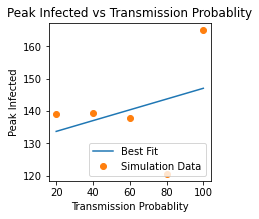

Best fit equation: time = 0.17x + 130.40


In [15]:
#Get best fit perameters
fitPeakInfectedPT, slopeInfectedPT, BInfectedPT = myLinFit(transArray, peakInfectedPT)

#Plot peaks vs time
plt.close()
plt.figure(figsize=(2.9,2.9))
plt.plot(transArray, fitPeakInfectedPT,label = 'Best Fit')
plt.plot(transArray, peakInfectedPT,'o',label = 'Simulation Data')
plt.title('Peak Infected vs Transmission Probablity')
plt.xlabel('Transmission Probablity')
plt.ylabel('Peak Infected')
plt.legend(loc = 'lower right')
plt.show()

print('Best fit equation: time = {:.2f}x + {:.2f}'.format(slopeInfectedPT,BInfectedPT))

# Chance of death



In [16]:
#Test how a change in transmition probablility 

#nParticles, radius, velocity, infected, sheltered, TransProbability, deathProbability, boxSize, recoveryTime , timeMax, dt
#                        n   r    v   inf she TP   DP  BS  RT  tmax  

DeathArray = np.arange(0,100,10)
peakInfectedDP = np.zeros(len(DeathArray ))
peakAtDP = np.zeros(len(DeathArray ))

print(DeathArray)

loopNum = 3
#Gather all peak values
for v in range(len(DeathArray)):
    peak = np.zeros(loopNum)
    peaktime = np.zeros(loopNum)
    for i in range(0,loopNum):
        time, tracked = runSim(200, 1.0, 2.0, 5, 0 , 100, DeathArray[v], 50, 10, 45, dt, False)
        peak[i] = max(tracked[1,:])
        peaktime[i] = int(np.argmax(tracked[1,:])*dt)

    peakAtDP[v] = sum(peaktime)/len(peaktime)
    peakInfectedDP[v] = sum(peak)/len(peak)
    #plotStatus(time,tracked)

[ 0 10 20 30 40 50 60 70 80 90]


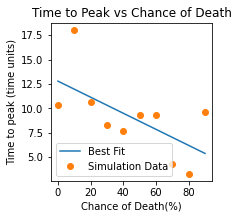

Best fit equation: time = -0.08x + 12.80


In [17]:
#Get best fit perameters
fitPeakAtDP, slopeDP, BDP = myLinFit(DeathArray, peakAtDP)

#Plot peaks vs time
plt.close()
plt.figure(figsize=(2.9,2.9))
plt.plot(DeathArray, fitPeakAtDP,label = 'Best Fit')
plt.plot(DeathArray, peakAtDP,'o',label = 'Simulation Data')
plt.title('Time to Peak vs Chance of Death')
plt.xlabel('Chance of Death(%)')
plt.ylabel('Time to peak (time units)')
plt.legend(loc = 'lower left')
plt.show()

print('Best fit equation: time = {:.2f}x + {:.2f}'.format(slopeDP,BDP))

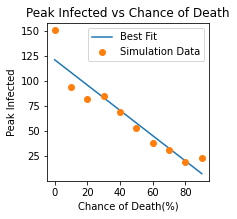

Best fit equation: time = -1.26x + 121.53


In [18]:
#Get best fit perameters
fitPeakInfectedDP, slopeInfectedDP, BInfectedDP = myLinFit(DeathArray, peakInfectedDP)

#Plot peaks vs time
plt.close()
plt.figure(figsize=(2.9,2.9))
plt.plot(DeathArray, fitPeakInfectedDP,label = 'Best Fit')
plt.plot(DeathArray, peakInfectedDP,'o',label = 'Simulation Data')
plt.title('Peak Infected vs Chance of Death')
plt.xlabel('Chance of Death(%)')
plt.ylabel('Peak Infected')
plt.legend(loc = 'upper right')
plt.show()

print('Best fit equation: time = {:.2f}x + {:.2f}'.format(slopeInfectedDP,BInfectedDP))